In [229]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow import keras

import cirq
import sympy
import numpy as np
import collections
import pandas as pd

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [2]:
#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_quantum as tfq

2022-05-31 13:39:28.046509: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load dataset

In [104]:
mat = np.load("./proj_raw_data_train_0.npz")['arr_0'] # change path to your data

In [105]:
# nan to zero 
mat[np.isnan(mat)] = 0

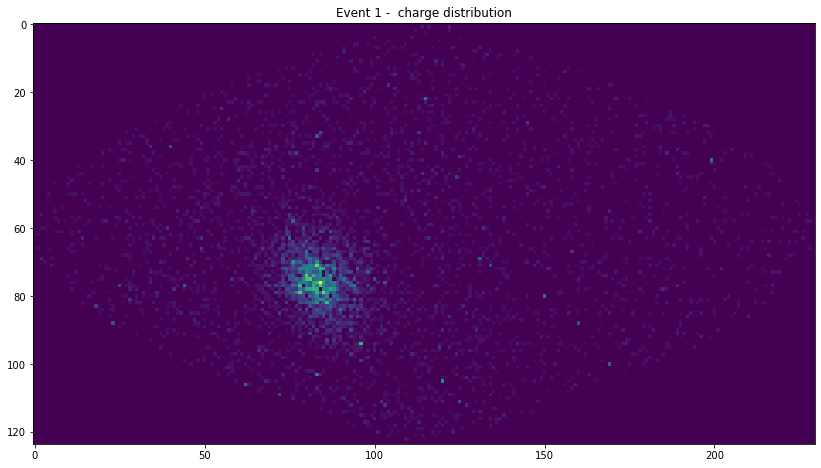

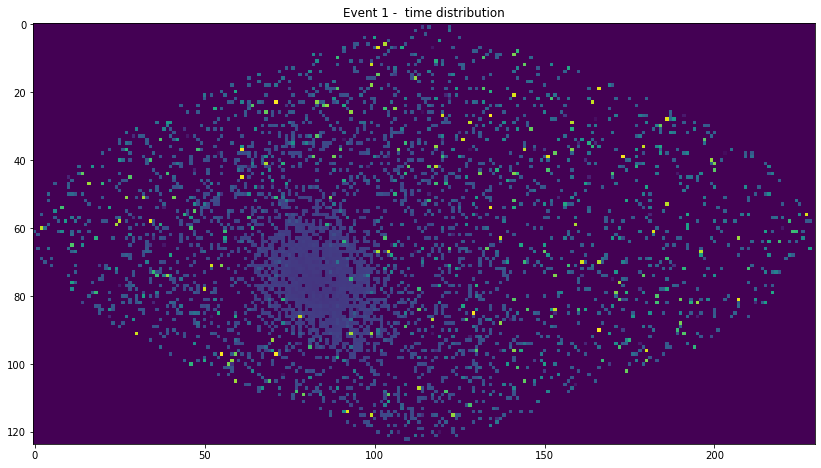

In [156]:
# event display
ev = 1

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  charge distribution".format(ev))
plt.imshow(mat[ev,:,:,0].T)

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  time distribution".format(ev))
plt.imshow(mat[ev,:,:,1].T)

## Reduce image resolution

In [135]:
def conv_juno(in_matrix, kernel_size, input_shape=(230, 124)):
    """Convolves the input image to reduce size"""
    '''k_s_0 = input_shape[0] - out_shape[0]*stride[0] + 1*stride[0]
    k_s_1 = input_shape[1] - out_shape[1]*stride[1] + 1*stride[1]
    kernel_size = (k_s_0, k_s_1)'''
    stride = kernel_size

    out_shape = np.zeros(2).astype(int)
    out_shape[0] = int((input_shape[0]-kernel_size[0])/stride[0] + 1)
    out_shape[1] = int((input_shape[1]-kernel_size[1])/stride[1] + 1)
    
    out_matrix = np.zeros((out_shape[0], out_shape[1], 2))

    # Loop over the image
    for j in range(0, input_shape[0] - kernel_size[0] + 1, stride[0]):
        for k in range(0, input_shape[1] - kernel_size[1] + 1, stride[1]):
            # sum charge over the kernel
            out_matrix[j  // stride[0], k  // stride[1], 0] = np.sum(in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 0])
            # charge weighted sum of time over the kernel
            weights = in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 0]
            elements = in_matrix[j:j+kernel_size[0], k:k+kernel_size[1], 1]
            out_matrix[j  // stride[0], k  // stride[1], 1] = np.sum(np.multiply(elements, weights))/np.sum(weights) \
                                                              if np.sum(weights) != 0 else 0
    return out_matrix

In [178]:
# convolve the image
conv_mat = conv_juno(mat[0], kernel_size=(4, 4))

In [179]:
 # set kernel size
kernel_size = (4, 4)

# for each event, convolve the image
conv_mat = np.zeros((mat.shape[0], conv_mat.shape[0], conv_mat.shape[1], conv_mat.shape[2]))
for i in range(mat.shape[0]):
    conv_mat[i] = conv_juno(mat[i], kernel_size)

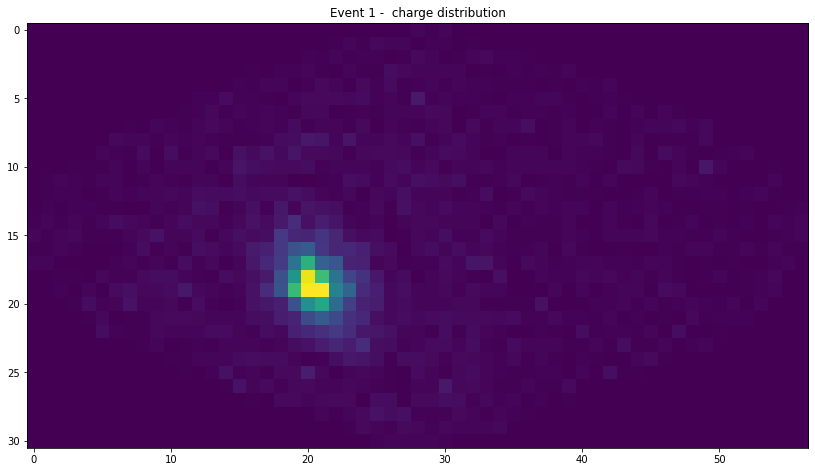

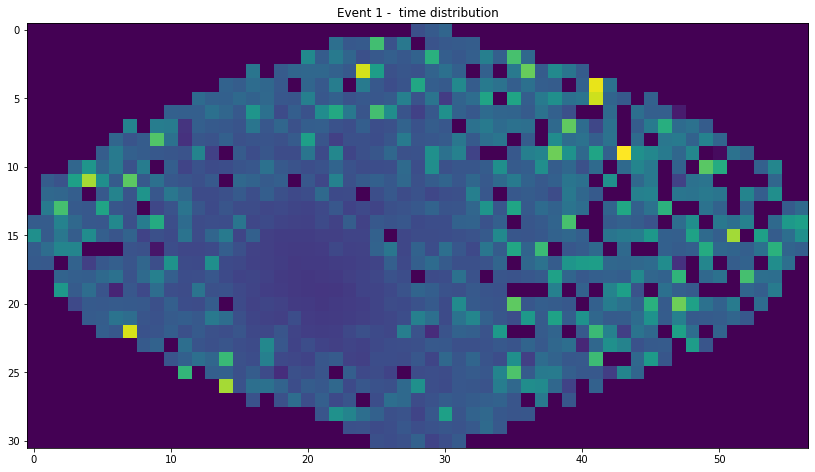

In [180]:
# event display
ev = 1

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  charge distribution".format(ev))
plt.imshow(conv_mat[ev, :,:,0].T)

fig = plt.figure(figsize=(14,14))
plt.title("Event {} -  time distribution".format(ev))
plt.imshow(conv_mat[ev, :,:,1].T)

## Test a simple CNN model

In [182]:
train_images = conv_mat
train_labels = np.array(pd.read_csv("targets_train_0.csv")["edep"])

In [194]:
train_images.shape

(5000, 57, 31, 2)

In [195]:
train_labels.shape

(5000,)

In [183]:
input_shape = (train_images.shape[1], train_images.shape[2])
channels    = train_images.shape[3]

In [226]:
def cnn_model(img_size = (57, 31),
              channels = 2):
    cnn_model = models.Sequential([
        layers.Conv2D(filters=8, kernel_size=2, activation='relu', strides = (2,2), input_shape=(img_size[0], img_size[1], channels), data_format='channels_last'),
        layers.AvgPool2D(pool_size=4, strides=2),
        layers.Conv2D(filters=16, kernel_size=2, activation='relu', strides = (1,1), input_shape=(img_size[0], img_size[1], channels), data_format='channels_last'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='relu')]
    )

    cnn_model.compile(
        optimizer='adam',
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    return cnn_model

In [227]:
cnn = cnn_model(
    img_size = input_shape,
    channels = channels
)
n_epochs = 40
batch_size = 64

In [228]:
cnn_history = cnn.fit(train_images,
                      train_labels,
                      validation_split = 0.3,
                      batch_size=batch_size,
                      epochs=n_epochs, 
                      verbose=2)

Epoch 1/40
55/55 - 1s - loss: 17.1952 - root_mean_squared_error: 4.1467 - val_loss: 2.6699 - val_root_mean_squared_error: 1.6340 - 1s/epoch - 25ms/step
Epoch 2/40
55/55 - 0s - loss: 3.8662 - root_mean_squared_error: 1.9663 - val_loss: 2.5067 - val_root_mean_squared_error: 1.5833 - 452ms/epoch - 8ms/step
Epoch 3/40
55/55 - 0s - loss: 2.5027 - root_mean_squared_error: 1.5820 - val_loss: 2.0704 - val_root_mean_squared_error: 1.4389 - 442ms/epoch - 8ms/step
Epoch 4/40
55/55 - 0s - loss: 1.9537 - root_mean_squared_error: 1.3978 - val_loss: 3.9174 - val_root_mean_squared_error: 1.9792 - 424ms/epoch - 8ms/step
Epoch 5/40
55/55 - 0s - loss: 1.7453 - root_mean_squared_error: 1.3211 - val_loss: 3.3043 - val_root_mean_squared_error: 1.8178 - 421ms/epoch - 8ms/step
Epoch 6/40
55/55 - 0s - loss: 1.4207 - root_mean_squared_error: 1.1919 - val_loss: 3.1764 - val_root_mean_squared_error: 1.7822 - 421ms/epoch - 8ms/step
Epoch 7/40
55/55 - 0s - loss: 1.2320 - root_mean_squared_error: 1.1100 - val_loss: 

In [ ]:
s~

## Trainable Quanvolutional NN